# Taller de IA - Redes Neuronales Artificiales (RNA)
***Solución a problemas de clasificación***


Variables sencillas para concentrarnos en las RNA ✅

Ejemplo basado en *la historia de la vida* 😊


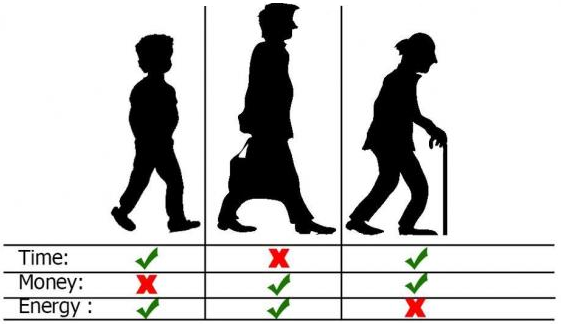

¿Ejemplos de problemas de ingeniería en dónde aplicar clasificación?

## Preprocesamiento de datos

Importación de módulos y librerías útiles

In [2]:
# Importación, visualización, manipulación de datos
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Transformación de datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report

# RNA
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# Visualización de resultados
from sklearn.metrics import confusion_matrix

In [69]:
# Archivos pueden arrastrarse al área de trabajo o procesarse en local

# Version Online
!wget https://github.com/AxelSkrauba/Taller_IA/raw/main/1_RNA_Classification/data_classification.zip

--2022-08-24 01:01:11--  https://github.com/AxelSkrauba/Taller_IA/blob/main/1_RNA_Classification/data_classification.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data_classification.zip’

data_classification     [ <=>                ] 132.59K  --.-KB/s    in 0.05s   

2022-08-24 01:01:12 (2.52 MB/s) - ‘data_classification.zip’ saved [135769]



In [70]:
!unzip data_classification.zip

Archive:  data_classification.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data_classification.zip or
        data_classification.zip.zip, and cannot find data_classification.zip.ZIP, period.


In [4]:
# Lectura del dataset
dataset = pd.read_csv("data.csv")

In [5]:
# Para visualizar un fragmento de los datos
dataset.head(5)

,tiempo,dinero,energia,clase
0,0.94,0.44,0.17,Anciano
1,0.81,0.02,0.84,Joven
2,0.89,0.06,0.94,Joven
3,0.84,0.09,0.31,Adulto
4,0.95,0.76,0.19,Anciano


In [6]:
# Para visualizar tipos de datos, cantidades, etc.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   tiempo   200 non-null    float64
 1   dinero   200 non-null    float64
 2   energia  200 non-null    float64
 3   clase    200 non-null    object 
dtypes: float64(3), object(1)
memory usage: 6.4+ KB


In [7]:
# Categorías disponibles en las variables categóricas
for col in dataset.columns:
    if dataset[col].dtype == 'object':
        print(col,"->", dataset[col].unique())

clase -> ['Anciano' 'Joven' 'Adulto']


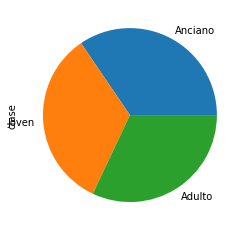

In [8]:
# Ejemplo de gráfica para una idea de las distribuciones
# En este caso... todo está medianamente equilibrado
# En la vida real es diferente
dataset['clase'].value_counts().plot.pie()

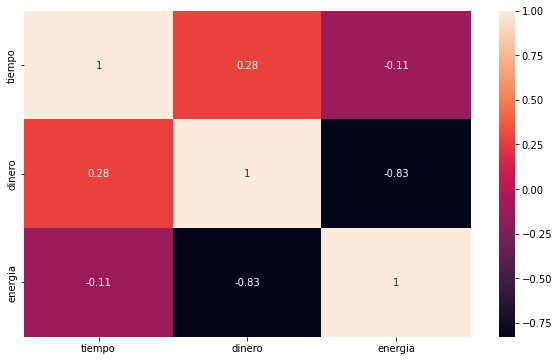

In [9]:
# Mapa de correlaciones, se puede observar dependencias entre columnas. Permite descartar descriptores que no aportan información nueva por ejemplo (resta costo computacional, etc.)
# Antes de plantear cualquier modelo, existe un gran trabajo de procesamiento y análisis de los datos. Herramientas Estadísticas juegan un roll fundamental.
sns.heatmap(data=dataset.corr(), annot=True)

fig=plt.gcf()
fig.set_size_inches(10,6)
plt.show()

# En este caso, por ejemplo, no se observan fuertes relaciones entre las variables. Por lo tanto, en principio existe información útil en todas.
# NOTA: variables aletorias tampoco estarán correlacionadas, pero en este punto, asumimos que anteriormente validamos que estas variables "tienen que ver" con nuestro problema.

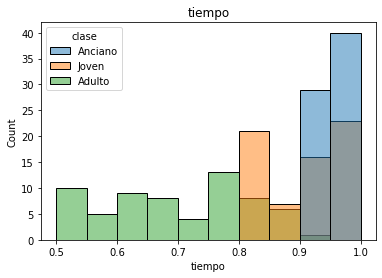

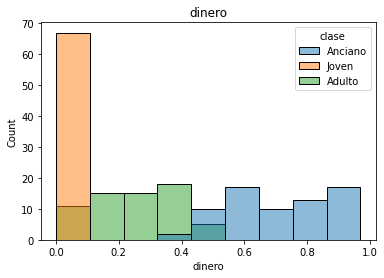

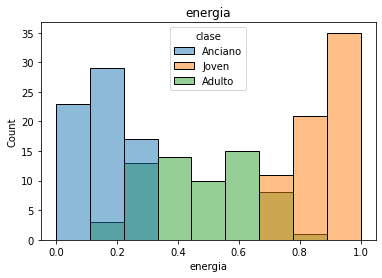

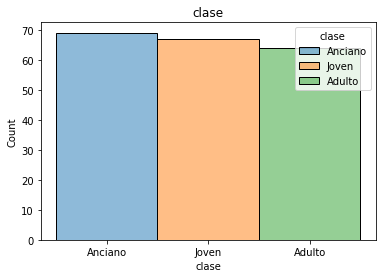

In [10]:
# Más ejemplos de gráficas. Distribuciones respecto a la salida
for col in dataset.columns:
    plt.title(col)
    sns.histplot(data=dataset, x = col, hue='clase')
    plt.show()

# Se aprecia por ejemplo, que existen superposiciones en los rangos de las variables. Por lo tanto, no sería tan sencillo clasificar las clases de salida
# y obtener una precisión buena con simples secuencias de selección (IF anidados por ejemplo, en dónde se establece un umbral estricto).

In [11]:
# Tratamiento de los datos y división del dataset

# Definición de la columna de salida esperada (aprendizaje supervisado)
y = dataset.pop('clase')
print("Y antes:\n", y[:5])

# Preprocesamiento
# Se codifica numéricamente las categorías definidas con etiquetas. Ej.: en lugar de “Joven” y “Adulto” en la clase, queda 0 y 1.
le = LabelEncoder()

y = le.fit_transform(y)     # Con le.inverse_transform() recuperamos luego la etiqueta original
print("Y despues: ", y[:5])

Y antes:
 0    Anciano
1      Joven
2      Joven
3     Adulto
4    Anciano
Name: clase, dtype: object
Y despues:  [1 2 2 0 1]


In [12]:
# Cantidad de datos a procesar.
print("Tamaño actual - Salida:", y.shape)

Tamaño actual - Salida: (200,)


In [13]:
X = np.asarray(dataset) # Esto se puede hacer directamente porque para y se usó pop sobre el dataframe.
print("Tamaño actual - Entrada:", X.shape) # Es importante que el tamaño sea consistente entre X e Y (Entrada y Salida).

Tamaño actual - Entrada: (200, 3)


In [14]:
# Ver datos de una determinada fila
index = 0
print("Tiempo: {} - Dinero: {} - Energía: {} || Clase: {}".format(X[index][0], X[index][1], X[index][2], le.inverse_transform(y)[index]))

Tiempo: 0.94 - Dinero: 0.44 - Energía: 0.17 || Clase: Anciano


## RNA - Topología manual

In [15]:
# División del dataset
# test_size: indica el porcentaje destinado a test/validacion
# random_state: un valor aleatorio cualquiera, sirve para garantizar repetibilidad. En este caso, en referencia a la subdivisión del set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [16]:
# Definición del tipo de modelo, capas, tamaños, etc.

"""
Más tipos de capas y funciones de activación en 'layers' de tensorflow
Ej.: from tensorflow.keras.layers import LeakyReLU, PReLU
softmax, softplus, softsign, tanh, selu, elu, exponential...
Cada una tiene sus propios argumentos. Ver ejemplos en: https://keras.io/api/layers/activations/
Para las capas, divertirse con: https://keras.io/api/layers/

Pequeña guía con ejemplos: https://www.tutorialspoint.com/keras/keras_layers.htm
En esta última, se presenta cuestiones como la inicialización personalizada de los pesos,
establecer límites para los mismos, etc.
"""

# Vamos a trabajar con modelos secuenciales únicamente
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(X.shape[1],))) # Es importante el tamaño de la capa de entrada
model.add(layers.Dropout(0.2)) # Es una estrategia para hacer robusto al modelo. Se indica una probabilidad para el apagado aleatorio de las neuronas de la capa.

# --- INICIO CAPAS OCULTAS ---
# Acá entra en juego la creatividad, se pueden agregar tantas capas como se quiera
# La cantidad de neuronas por capa no generará ningún inconveniente en el modelo
# Pueden probar diferentes configuraciones, funciones de activación, etc.
# Charlamos respecto a qué pasa. Abajo vemos entrenamiento, desempeño...
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dropout(0.2))
# --- FIN CAPAS OCULTAS ---

model.add(layers.Dense(3, activation='softmax')) # Es importante el tamaño de la capa de salida, es 3 porque vamos a usar 'sparse_categorical_crossentropy' para la pérdida. Y tenemos 3 categorías o clases para la clasifición.

# Para visualizar la topología resultante
model.summary()

# Notar que aparece un término como "Non-trainable params". Esto se utiliza por ejemplo, para transferencia de aprendizaje.
# Podemos utilizar un red entrenada para algo parecido a nuestras necesidades, bloqueamos el entrenamiento en ciertas capas, y entrenamos solamente las capas nuevas.
# Es un adelanto simplemente :)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                40        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Se define el optimizador a utilizar, tasa de aprendizaje y otros argumentos a utilizar. Por ej: la métrica de referencia será el accuracy
# Los parámetros del compilador... quedan para otra ocasión.
model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Se entrena el modelo y se guardan los resultados. Se define un límite de épocas y el tamaño de lotes a usar.
# El máximo para el lote es la cantidad de datos disponibles, conviene utilizar uno tal que permita un número significativo de mezclas a lo largo de las épocas.
history = model.fit(X, y, epochs=200, batch_size=20)

Epoch 1/200
10/10 [==============================] - 1s 4ms/step - loss: 1.2012 - accuracy: 0.2300
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 1.2030 - accuracy: 0.1200
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1861 - accuracy: 0.0950
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1923 - accuracy: 0.1300
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1713 - accuracy: 0.1400
Epoch 6/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1833 - accuracy: 0.1000
Epoch 7/200
10/10 [==============================] - 0s 3ms/step - loss: 1.1761 - accuracy: 0.1000
Epoch 8/200
10/10 [==============================] - 0s 3ms/step - loss: 1.1763 - accuracy: 0.1200
Epoch 9/200
10/10 [==============================] - 0s 3ms/step - loss: 1.1754 - accuracy: 0.1200
Epoch 10/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1608 - accuracy: 0.1200
Epoch 11/

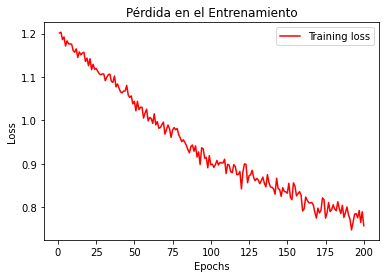

In [18]:
# Una gráfica simple de la evolución de la pérdida durante las épocas que duró el entrenamiento
# De acá se puede extraer mucha información importante respecto a cómo se desempeña la topología establecida. Lo charlamos
history_dict = history.history
loss_values = history_dict['loss']
epochs = range(1, len(history_dict['accuracy']) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.title('Pérdida en el Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

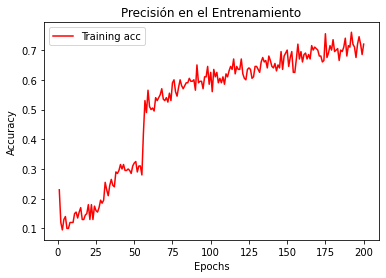

In [19]:
# Ídem, gráfica pero para la precisión de la RNA a lo largo del entrenamiento. Es de esperarse, que con cada época... la precisión aumente
# También se obtiene mucha información respecto a, por ejemplo, si la RNA es capaz de generalizar los datos o simplemente se los memoriza.
# Si más entrenamiento es conveniente o no, entre otros.
plt.clf()
acc_values = history_dict['accuracy']
plt.plot(epochs, history_dict['accuracy'], 'r', label='Training acc')
plt.title('Precisión en el Entrenamiento')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
# Evaluación del modelo sobre el set para test
# Esos son valores que no se usaron para entrenar. Si, por ejemplo, la red tiene un desempeño muy bueno durante el entrenamiento, pero con datos nuevos es mala...
# Significa que está sobre entrenada, se memorizó los valores. (overfitting)

result = model.evaluate(X_test, y_test) # Devuelve pérdida y accuracy
result

1/1 [==============================] - 0s 155ms/step - loss: 0.6037 - accuracy: 0.9000


[0.6036785244941711, 0.8999999761581421]

In [21]:
# Guardo las predicciones del modelos para analizarlas
y_pred = model.predict(X_test)
y_pred

# Las prediciones vienen en listas. Cada fila corresponde a una predicción.
# En cada lista, se tienen las probabilidades de pertenencia a cada clase
# Una forma rápida de determinar a qué clase pertenecen los datos de entrada,
# es seleccionando la clase con mayor probabilidad

array([[0.19013578, 0.77113426, 0.03872998],
       [0.3386379 , 0.25543025, 0.40593192],
       [0.3676184 , 0.28141457, 0.35096702],
       [0.34985885, 0.27262142, 0.37751976],
       [0.17699732, 0.789821  , 0.03318167],
       [0.19340892, 0.7671737 , 0.03941743],
       [0.3386379 , 0.25543025, 0.40593192],
       [0.16312441, 0.8124472 , 0.0244284 ],
       [0.22845958, 0.7208674 , 0.05067304],
       [0.18571313, 0.77697796, 0.03730894],
       [0.3386379 , 0.25543025, 0.40593192],
       [0.1433723 , 0.8394127 , 0.01721506],
       [0.39986402, 0.39182872, 0.20830731],
       [0.38494566, 0.34846038, 0.2665939 ],
       [0.17899303, 0.7897718 , 0.03123517],
       [0.34410927, 0.5005415 , 0.15534925],
       [0.23987387, 0.70511645, 0.0550097 ],
       [0.1510447 , 0.82895005, 0.02000518],
       [0.39248544, 0.35081878, 0.25669578],
       [0.38739693, 0.34511465, 0.26748845]], dtype=float32)

In [22]:
# Pequeña función para evaluar la respuesta y obtener la clase emergente
# En esta función se busca la clase con mayor probabilidad
# Hay métodos hechos que hacen toda esta tarea, pero va a modo demostrativo
# Se puede operar todo según las necesidades a resolver.

def predict_class(y_pred):
    y_class = []
    for i in y_pred:
        y_class.append(int(np.where(i == np.amax(i))[0]))
    
    return np.array(y_class)

In [23]:
y_pred_class = predict_class(y_pred)
# Ahora se puede comparar directamente y_pred con y_test

In [24]:
y_pred_class

array([1, 2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 1, 1, 1, 0, 0])

In [25]:
y_test

array([1, 2, 0, 0, 1, 1, 2, 1, 1, 1, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0])

In [26]:
# Si hay pocos datos, es fácil comparar visualmente
# Pero no es normal hacerlo así. Se utilizan herramientas y/o métricas
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.91      1.00      0.95        10
           2       0.75      1.00      0.86         3

    accuracy                           0.90        20
   macro avg       0.89      0.90      0.88        20
weighted avg       0.92      0.90      0.90        20



In [27]:
# Visualización de los resultados utilizando la matriz de confusión
# Lo ideal es que hayan valores únicamente en la diagonal principal de la matriz
# Significa que... la RNA clasificó correctamente cada observación. Charlamos sobre esto un poco.
confusion_matrix(y_test,y_pred_class)

array([[ 5,  1,  1],
       [ 0, 10,  0],
       [ 0,  0,  3]])

## RNA - Topología manual V2

In [52]:
# Espacio para hacer otro modelo, se puede copiar y pegar la base de arriba :)
# Ejemplo

model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(X.shape[1],))) # Sigue siendo importante el tamaño de la capa de entrada
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(3, activation='softmax')) # Sigue siendo importante el tamaño de la capa de salida

# ¿RNA más grande significa mejor desempeño?

In [53]:
# Para visualizar la topología resultante
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 4)                 16        
                                                                 
 dropout_40 (Dropout)        (None, 4)                 0         
                                                                 
 dense_46 (Dense)            (None, 4)                 20        
                                                                 
 dropout_41 (Dropout)        (None, 4)                 0         
                                                                 
 dense_47 (Dense)            (None, 8)                 40        
                                                                 
 dropout_42 (Dropout)        (None, 8)                 0         
                                                                 
 dense_48 (Dense)            (None, 16)               

In [58]:
# El compilador lo dejamos igual
model.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [55]:
# División del dataset (igual que el anterior, cambian proporciones)
# Ahora llamamos "validación" a la otra parte de la subdivisión. Pero es lo mismo
# Esta vez vamos a usar en cada época una porción de datos para verificar de otra manera el desempeño
# Después... hacemos test con datos que la red nunca vio (el otro csv)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

In [56]:
# Si se cambia test_size, la proporción cambia
# Estamos trabajando con pocas entradas
print("Tamaño Entrenamiento: ", X_train.shape)
print("Tamaño Validación: ", X_val.shape)

Tamaño Entrenamiento:  (140, 3)
Tamaño Validación:  (60, 3)


In [59]:
# Criterio de parada anticipada, si probaste una topología grande... se podrá intuir para qué sirve esto
# monitor: variable que "mira" para decidir si hay que terminar antes el entrenamiento
# min_delta: sensibilidad admitida / resolución
# patience: cantidad de épocas que espera en búsqueda de alguna mejora
# restore_best_weights: si está en True, recupera los mejores pesos encontrados
# verbose: para mostrar diferentes niveles de mensajes. En 0 no avisa nada, en 1 avisa que se paró por los criterios establecidos, etc
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, restore_best_weights=True, verbose = 1)

# Para el entrenamiento, usamos otros datos para la validación del modelo
# En el historial se guardan la información para el proceso con datos de validación
history = model.fit(X_train, y_train, epochs=800, batch_size=10, validation_data=(X_val, y_val), callbacks=early_stopping)

Epoch 1/800
14/14 [==============================] - 1s 20ms/step - loss: 1.0997 - accuracy: 0.3500 - val_loss: 1.0985 - val_accuracy: 0.2333
Epoch 2/800
14/14 [==============================] - 0s 6ms/step - loss: 1.1019 - accuracy: 0.3429 - val_loss: 1.0988 - val_accuracy: 0.2333
Epoch 3/800
14/14 [==============================] - 0s 5ms/step - loss: 1.0978 - accuracy: 0.4000 - val_loss: 1.0988 - val_accuracy: 0.2333
Epoch 4/800
14/14 [==============================] - 0s 4ms/step - loss: 1.0984 - accuracy: 0.3786 - val_loss: 1.0991 - val_accuracy: 0.2333
Epoch 5/800
14/14 [==============================] - 0s 6ms/step - loss: 1.0975 - accuracy: 0.3929 - val_loss: 1.0991 - val_accuracy: 0.2333
Epoch 6/800
14/14 [==============================] - 0s 5ms/step - loss: 1.0966 - accuracy: 0.3857 - val_loss: 1.0990 - val_accuracy: 0.2333
Epoch 7/800
14/14 [==============================] - 0s 5ms/step - loss: 1.0960 - accuracy: 0.4143 - val_loss: 1.0992 - val_accuracy: 0.2333
Epoch 8/800


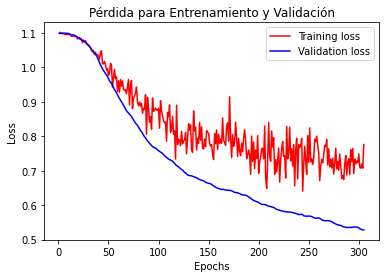

In [60]:
# Notar que el entrenamiento anterior finaliza antes de las épocas totales establecidas para el fit, justamente por el nuevo criterio de parada
# Entrena hasta que se cumpla algún criterio
# En este caso, se entrenó hasta una determinada pérdida en el set de validación. Es de esperarse, que sobre un set de test se obtenga un resultado muy parecido.

# Ahora se disponen de los datos para el set de validación
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(history_dict['accuracy']) + 1)
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Pérdida para Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

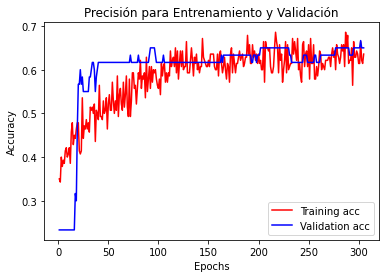

In [61]:
plt.clf()
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
plt.plot(epochs, history_dict['accuracy'], 'r', label='Training acc')
plt.plot(epochs, history_dict['val_accuracy'], 'b', label='Validation acc')
plt.title('Precisión para Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# De estas curvas se pueden obtener varias conclusiones respecto a la red.
# En principio, deben ser bastante parecidas tanto train como val, reflejando el aprendizaje de la RNA
# El desempeño sobre val suele ser menor, son datos no utilizados para el entrenamiento (de forma directa)
# Si en val se obtienen cosas muy diferentes (respecto a train), al realizar predicciones sobre el set para test va a pasar algo muy parecido (a lo que pasó con val)
# Muy resumido todo, cada cuestión tiene de fondo un análisis extensivo.

## Prueba sobre datos que la RNA nunca vio

In [62]:
# Abrimos el otro csv
dataset_test = pd.read_csv("data_test.csv")

# Hay que procesar de la misma forma que los datos usados para entrenar
y_test = dataset_test.pop('clase')
y_test = le.fit_transform(y_test)
X_test = np.asarray(dataset_test)

In [63]:
# Se hacen las predicciones y se compara con los valores reales
y_pred = model.predict(X_test)
y_pred_class = predict_class(y_pred)
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      0.03      0.07        29
           1       0.97      1.00      0.98        32
           2       0.59      1.00      0.74        39

    accuracy                           0.72       100
   macro avg       0.85      0.68      0.60       100
weighted avg       0.83      0.72      0.62       100



In [64]:
confusion_matrix(y_test,y_pred_class)

array([[ 1,  1, 27],
       [ 0, 32,  0],
       [ 0,  0, 39]])

Si es confuso/complejo ver las clases con números, siempre puedo volver a las etiquetas originales

In [65]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(y_pred_class)))

              precision    recall  f1-score   support

      Adulto       1.00      0.03      0.07        29
     Anciano       0.97      1.00      0.98        32
       Joven       0.59      1.00      0.74        39

    accuracy                           0.72       100
   macro avg       0.85      0.68      0.60       100
weighted avg       0.83      0.72      0.62       100



In [66]:
# Arreglo codificado
y_pred_class

array([1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1,
       2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2])

In [67]:
# Arreglo DEcodificado
le.inverse_transform(y_pred_class)

array(['Anciano', 'Joven', 'Joven', 'Anciano', 'Joven', 'Joven', 'Joven',
       'Joven', 'Anciano', 'Joven', 'Anciano', 'Anciano', 'Anciano',
       'Joven', 'Joven', 'Joven', 'Joven', 'Joven', 'Joven', 'Joven',
       'Joven', 'Joven', 'Joven', 'Joven', 'Joven', 'Anciano', 'Anciano',
       'Joven', 'Joven', 'Joven', 'Joven', 'Anciano', 'Anciano',
       'Anciano', 'Anciano', 'Joven', 'Joven', 'Anciano', 'Joven',
       'Joven', 'Joven', 'Joven', 'Joven', 'Joven', 'Anciano', 'Anciano',
       'Joven', 'Anciano', 'Joven', 'Joven', 'Joven', 'Joven', 'Joven',
       'Joven', 'Joven', 'Joven', 'Anciano', 'Anciano', 'Joven', 'Joven',
       'Anciano', 'Joven', 'Joven', 'Anciano', 'Joven', 'Anciano',
       'Joven', 'Joven', 'Joven', 'Joven', 'Joven', 'Joven', 'Anciano',
       'Joven', 'Adulto', 'Joven', 'Anciano', 'Anciano', 'Joven',
       'Anciano', 'Anciano', 'Joven', 'Anciano', 'Joven', 'Joven',
       'Anciano', 'Joven', 'Anciano', 'Joven', 'Anciano', 'Joven',
       'Anciano', 'Anc